In [1]:
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from copy import deepcopy
import os
from scipy.stats import pearsonr
from scipy.spatial.distance import braycurtis
from sklearn.metrics import r2_score
from scipy import stats
from statannot import add_stat_annotation
%matplotlib inline

# Read taxonomy

In [2]:
df_tax = pd.read_csv('qiime2_output/taxonomy.tsv', sep="\t").rename({'Feature ID':'ASV'}, axis=1)
df_tax = df_tax[df_tax.Taxon.str.contains('d__Bacteria')]
df_tax = df_tax[~(df_tax.Taxon.str.contains('Chloroplast') | df_tax.Taxon.str.contains('Mitochondria'))]
df_tax['LowestTaxonomy'] = [t.split(';')[-1].strip() for t in df_tax.Taxon]
df_tax.head()

,ASV,Taxon,Confidence,LowestTaxonomy
0,f5f5e0da89730462abaf6301a9557193,d__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.997650,g__Faecalibacterium
1,818434292143daca42a3168f3728da82,d__Bacteria; p__Firmicutes; c__Negativicutes; ...,0.999921,g__Dialister
2,99deb3c5ecb022ec05609ebd1112a557,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,1.000000,g__Bacteroides
3,35ffcc3b809d667286737d79670b8de5,d__Bacteria; p__Actinobacteriota; c__Actinobac...,0.999932,g__Bifidobacterium
4,c48070f3061b086b60ff32f77e0002fa,d__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.994947,g__Subdoligranulum


# Read metadata

In [3]:
df_meta = pd.read_csv("metadata.csv")
df_meta = df_meta[df_meta.BodySubSite == "Stool"]
df_run = pd.read_csv("qiime2_output/SraRunTable.txt")[['Run','Sample Name']]
df_run.columns = ['Run','SampleID']
df_meta = pd.merge(df_meta, df_run, left_on='SampleID', right_on='SampleID', how='inner').set_index('Run')
df_meta.head()

,SampleID,SubjectID,BodySubSite,Timepoint,Age,Gender,Race/Ethnicity,Medication,Antibiotic,DetailedDiagnosis,DiseaseLocation,Inflammation,BodySite,RefDate,Disease,SequencingAssay,Study,PatientGeo,MedicationWhen
Run,,,,,,,,,,,,,,,,,,,
SRR8057056,G94766,8477,Stool,Week 0,7,Female,Black,5-aminosalicylic acid,No,Mild,Pancolitis/Unassessable,NaN,Gastrointestinal_tract,Baseline sample collection,UC,Amplicon,uc_schirmer2018_cellhostmicrobe,North America,Week 0
SRR8057057,G94718,8155,Stool,Week 4,15,Female,White,Corticosteroids(iv),No,Mild,Pancolitis/Unassessable,Calprotectin (219.75528),Gastrointestinal_tract,Baseline sample collection,UC,Amplicon,uc_schirmer2018_cellhostmicrobe,North America,Week 0
SRR8056960,G94719,2648,Stool,Week 4,17,Female,White,Corticosteroids(oral),No,Inactive,Pancolitis/Unassessable,Calprotectin (1772.42472),Gastrointestinal_tract,Baseline sample collection,UC,Amplicon,uc_schirmer2018_cellhostmicrobe,North America,Week 0
SRR8056969,G94713,9660,Stool,Week 0,8,Female,Black,Corticosteroids(iv),Yes,Severe,Pancolitis/Unassessable,NaN,Gastrointestinal_tract,Baseline sample collection,UC,Amplicon,uc_schirmer2018_cellhostmicrobe,North America,Week 0
SRR8057214,G75041,10272,Stool,Week 0,16,Female,White,5-aminosalicylic acid,No,Mild,Left-sided colitis,Calprotectin (506.40194),Gastrointestinal_tract,Baseline sample collection,UC,Amplicon,uc_schirmer2018_cellhostmicrobe,North America,Week 0


# Read count data (filter out samples with less than 1000 reads)

In [4]:
df_count = pd.read_csv('qiime2_output/feature-table/feature-table.from_biom.txt', sep="\t", index_col=0, skiprows=[0])
df_count = df_count.loc[df_tax['ASV']].T
sample_ids_w_suff_reads = list(df_count.sum(axis=1)[df_count.sum(axis=1)>=1000].index)
df_count = df_count.loc[set(df_meta.index).intersection(set(sample_ids_w_suff_reads))]
df_count = df_count.loc[:, (df_count != 0).any(axis=0)]
print("minimum total count = %d" % df_count.sum(axis=1).min())
df_relabun = df_count.div(df_count.sum(axis=1), axis=0)
df_relabun.head()

minimum total count = 2029


#OTU ID,f5f5e0da89730462abaf6301a9557193,818434292143daca42a3168f3728da82,99deb3c5ecb022ec05609ebd1112a557,35ffcc3b809d667286737d79670b8de5,c48070f3061b086b60ff32f77e0002fa,d46e2205f0c6ecf67b51f83d111c509c,2c982937754e6321f861027032db80f7,263e41ea2c25dc87bd2ff5910cf30d40,5a6c87d6a4eb5e114959f6192f29b641,c6c3ab4e828fb40d6e05967b7aac9338,...,bbc5ff26032af57118539fdf571caf37,ccd6a09ac75efbe0badf61da07f694c7,0d22c8b07f0975621c48cfc8fd337166,75dbf572703e52e5af890b0b4a8c1480,d1063cb798d593012c9e37aa7b643e6c,0fbc98627b42a9148e88becc2e16aaab,37b5fe07ccc2935973ec03aab6c5eb2d,643b53ee620340cb2021259c37c48da1,6b518bfc1b79e27a9ca3774e7941d4bd,618f29ee833231806abe023c17bfe009
SRR8057488,0.138717,0.048568,0.004281,0.023759,0.000835,0.020474,0.072529,0.030570,0.020151,0.005088,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR8058464,0.078194,0.047752,0.000000,0.004059,0.000000,0.082807,0.002572,0.050607,0.014879,0.006560,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR8058555,0.080462,0.000000,0.005726,0.010672,0.026875,0.000000,0.000000,0.032862,0.052676,0.037384,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR8056954,0.055617,0.199357,0.031582,0.040098,0.046841,0.003880,0.023515,0.066973,0.025266,0.034941,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR8056958,0.125028,0.068087,0.166749,0.001073,0.000000,0.090626,0.000193,0.048464,0.000000,0.012439,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df_blast_HMPv35oral = pd.read_csv("qiime2_output/asv-sequences/blast_HMPv35oral/blast_HMPv35oral_p100.txt", sep="\t", comment="#", header=None)
df_blast_HMPv35oral.columns = ['query_accver', 'subject_accver', 'perc_identity', 'alignment_length', 'mismatches', 'gap_opens', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']
df_oral = df_relabun[set(df_relabun.columns).intersection(set(df_blast_HMPv35oral.query_accver))].sum(axis=1).to_frame().rename({0:'OralFrac'}, axis=1)
df_meta_oral = pd.merge(df_meta, df_oral, left_index=True, right_index=True, how='inner')
df_meta_oral['log10_OralFrac'] = np.log10(df_meta_oral['OralFrac'])
df_meta_oral = df_meta_oral[df_meta_oral.Antibiotic=='No']
df_meta_oral = df_meta_oral[df_meta_oral.DetailedDiagnosis.notnull()]
df_meta_oral.head()

/Users/liaoc/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,SampleID,SubjectID,BodySubSite,Timepoint,Age,Gender,Race/Ethnicity,Medication,Antibiotic,DetailedDiagnosis,...,Inflammation,BodySite,RefDate,Disease,SequencingAssay,Study,PatientGeo,MedicationWhen,OralFrac,log10_OralFrac
SRR8057056,G94766,8477,Stool,Week 0,7,Female,Black,5-aminosalicylic acid,No,Mild,...,NaN,Gastrointestinal_tract,Baseline sample collection,UC,Amplicon,uc_schirmer2018_cellhostmicrobe,North America,Week 0,0.138219,-0.859431
SRR8057057,G94718,8155,Stool,Week 4,15,Female,White,Corticosteroids(iv),No,Mild,...,Calprotectin (219.75528),Gastrointestinal_tract,Baseline sample collection,UC,Amplicon,uc_schirmer2018_cellhostmicrobe,North America,Week 0,0.005961,-2.224661
SRR8056960,G94719,2648,Stool,Week 4,17,Female,White,Corticosteroids(oral),No,Inactive,...,Calprotectin (1772.42472),Gastrointestinal_tract,Baseline sample collection,UC,Amplicon,uc_schirmer2018_cellhostmicrobe,North America,Week 0,0.004730,-2.325122
SRR8057214,G75041,10272,Stool,Week 0,16,Female,White,5-aminosalicylic acid,No,Mild,...,Calprotectin (506.40194),Gastrointestinal_tract,Baseline sample collection,UC,Amplicon,uc_schirmer2018_cellhostmicrobe,North America,Week 0,0.131130,-0.882297
SRR8057054,G94711,11668,Stool,Week 0,14,Female,White,Corticosteroids(iv),No,Severe,...,Calprotectin (795.24044),Gastrointestinal_tract,Baseline sample collection,UC,Amplicon,uc_schirmer2018_cellhostmicrobe,North America,Week 0,0.157537,-0.802618


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Inactive v.s. Mild: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.652e-03 stat=1.194e+01
Inactive v.s. Moderate: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.438e-07 stat=2.980e+01
Inactive v.s. Severe: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.493e-23 stat=1.022e+02


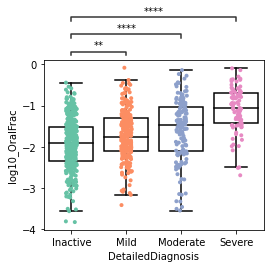

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4))

PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'k'},
    'medianprops':{'color':'k'},
    'whiskerprops':{'color':'k'},
    'capprops':{'color':'k'}
}
_ = sns.stripplot(x="DetailedDiagnosis", y="log10_OralFrac", data=df_meta_oral, palette="Set2", ax=ax, order=['Inactive','Mild','Moderate','Severe'], s=4)
_ = sns.boxplot(x="DetailedDiagnosis", y="log10_OralFrac", data=df_meta_oral, palette="Set2", ax=ax, order=['Inactive','Mild','Moderate','Severe'], showfliers=False, **PROPS)
test_results = add_stat_annotation(ax, data=df_meta_oral, x="DetailedDiagnosis", y="log10_OralFrac", order=['Inactive','Mild','Moderate','Severe'],
                                   box_pairs=[("Inactive", "Mild"),("Inactive","Moderate"),("Inactive","Severe")],
                                   test='Kruskal', text_format='star',
                                   loc='outside', verbose=2)

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("boxplot_pediatric_UC.svg", dpi=600, bbox_inches='tight')